## Fake News using Artificial Immune Systems 

### Data

✅ politifact_real.csv → real articles from Politifact 

✅ politifact_fake.csv → fake articles from Politifact

✅ gossipcop_real.csv → real articles from GossipCop

✅ gossipcop_fake.csv → fake articles from GossipCop

### 📚 [References](https://github.com/KaiDMML/FakeNewsNet)

- Shu, K., Mahudeswaran, D., Wang, S., Lee, D., & Liu, H. (2018). **FakeNewsNet: A Data Repository with News Content, Social Context and Dynamic Information for Studying Fake News on Social Media.** *arXiv preprint arXiv:1809.01286*. [arXiv link](https://arxiv.org/abs/1809.01286)

- Shu, K., Sliva, A., Wang, S., Tang, J., & Liu, H. (2017). **Fake News Detection on Social Media: A Data Mining Perspective.** *ACM SIGKDD Explorations Newsletter*, 19(1), 22–36. [DOI](https://doi.org/10.1145/3137597.3137600)

- Shu, K., Wang, S., & Liu, H. (2017). **Exploiting Tri-Relationship for Fake News Detection.** *arXiv preprint arXiv:1712.07709*. [arXiv link](https://arxiv.org/abs/1712.07709)
✅ Includes 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

Matplotlib is building the font cache; this may take a moment.


In [7]:
# Load real and fake from politifact
basepath = "/Users/ayeshamendoza/repos/fake-news-immune-system"
datapath = os.path.join(basepath, "data/raw")
real = pd.read_csv(os.path.join(datapath, 'politifact_real.csv'))
fake = pd.read_csv(os.path.join(datapath, 'politifact_fake.csv'))

print("Real news shape:", real.shape)
print("Fake news shape:", fake.shape)

print("\nSample real news article:")
print(real.iloc[0])

print("\nSample fake news article:")
print(fake.iloc[0])

Real news shape: (624, 4)
Fake news shape: (432, 4)

Sample real news article:
id                                             politifact14984
news_url                             http://www.nfib-sbet.org/
title              National Federation of Independent Business
tweet_ids    967132259869487105\t967164368768196609\t967215...
Name: 0, dtype: object

Sample fake news article:
id                                             politifact15014
news_url             speedtalk.com/forum/viewtopic.php?t=51650
title        BREAKING: First NFL Team Declares Bankruptcy O...
tweet_ids    937349434668498944\t937379378006282240\t937380...
Name: 0, dtype: object


Data Preprocessing

In order to be able to use the text data in our Deep Learning models, we will need to convert the text data to numbers.  In order to do that the following pre-processing steps were done:

- Tokenization
- Stemming
- removing stopwords
- removing punctuations
- TF-IDF

In [ ]:
import pandas as pd
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

# Download NLTK resources if not done
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')

# Define cleaning function
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem import PorterStemmer
import string
import re



In [34]:
def clean_text(text):
    stop_words = ENGLISH_STOP_WORDS
    stemmer = PorterStemmer()

    text = text.lower()
    text = re.sub(r'\.{2,}', ' ', text)              # remove ellipsis
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text) # remove URLs
    text = re.sub(r'\$\w*', '', text)                # remove $ mentions
    text = re.sub(r'#', '', text)                    # remove hashtags
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)  # <-- remove punctuation

    tokens = text.split()  # now safe to split on whitespace

    cleaned_tokens = [
        stemmer.stem(token)
        for token in tokens
        if token not in stop_words
    ]

    return ' '.join(cleaned_tokens)



# Load dataset
basepath = "/Users/ayeshamendoza/repos/fake-news-immune-system"
datapath = os.path.join(basepath, "data/raw")
real = pd.read_csv(os.path.join(datapath, 'politifact_real.csv'))
fake = pd.read_csv(os.path.join(datapath, 'politifact_fake.csv'))

# Add label columns
real['label'] = 'REAL'
fake['label'] = 'FAKE'

# Combine datasets
df = pd.concat([real, fake], ignore_index=True)



In [35]:
# Apply cleaning
df['clean_text'] = df['title'].fillna('')
df['clean_text'] = df['clean_text'].apply(clean_text)
# df['clean_text'] = df['title'].fillna('').apply(clean_text)

# OPTIONAL: Save cleaned dataset
df.to_csv('../data/processed/cleaned_articles.csv', index=False)

# Preview cleaned text
print(df[['label', 'clean_text']].head())

# ✅ TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = vectorizer.fit_transform(df['clean_text'])

print("TF-IDF matrix shape:", tfidf_matrix.shape)


  label                                         clean_text
0  REAL                         nation feder independ busi
1  REAL                              comment fayettevil nc
2  REAL  romney make pitch hope close deal elect rocki ...
3  REAL  democrat leader say hous democrat unit gop def...
4  REAL                   budget unit state govern fy 2008
TF-IDF matrix shape: (1056, 2740)


In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer


# Fit TF-IDF
# vectorizer = TfidfVectorizer(max_features=5000)  # limit vocab to top 5000 tokens
vectorizer = TfidfVectorizer(
    max_features=5000,
    token_pattern=r'(?u)\b[a-zA-Z]{2,}\b'
)
tfidf_matrix = vectorizer.fit_transform(df['clean_text'])

# Vocab size
print(f"Vocabulary size: {len(vectorizer.vocabulary_)}")

# Preview first 20 tokens in vocab
print("\nSample vocab tokens:")
sample_tokens = list(vectorizer.vocabulary_.keys())[:20]
print(sample_tokens)

# Show shape
print(f"\nTF-IDF matrix shape: {tfidf_matrix.shape}")

# Show top tokens by IDF (most unique)
idf_scores = vectorizer.idf_
tokens_idf = sorted(zip(vectorizer.get_feature_names_out(), idf_scores), key=lambda x: -x[1])
print("\nTop 10 tokens by IDF (most unique):")
for token, idf in tokens_idf[:10]:
    print(f"{token}: {idf:.2f}")


Vocabulary size: 2610

Sample vocab tokens:
['nation', 'feder', 'independ', 'busi', 'comment', 'fayettevil', 'nc', 'romney', 'make', 'pitch', 'hope', 'close', 'deal', 'elect', 'rocki', 'mountain', 'news', 'democrat', 'leader', 'say']

TF-IDF matrix shape: (1056, 2610)

Top 10 tokens by IDF (most unique):
abandon: 7.27
abedin: 7.27
abid: 7.27
abortion: 7.27
absorb: 7.27
abus: 7.27
achiev: 7.27
acquir: 7.27
activ: 7.27
actuari: 7.27


In [40]:
basepath

'/Users/ayeshamendoza/repos/fake-news-immune-system'

In [42]:
from scipy import sparse

savepath = os.path.join(basepath, "data/processed")
df.to_csv(os.path.join(savepath, "clean_articles.csv"), index=False)

sparse.save_npz(os.path.join(savepath, "tfidf_matrix.npz"), tfidf_matrix)

# Save vocab
import pickle
with open(os.path.join(savepath,'tfidf_vocab.pkl'), 'wb') as f:
    pickle.dump(vectorizer.vocabulary_, f)

In [68]:
import sys
sys.path.append('../') 
import src.negative_selection
import importlib
importlib.reload(src.negative_selection)

from src.negative_selection import generate_detectors
from scipy import sparse

# Load saved tfidf matrix
self_matrix = sparse.load_npz(os.path.join(savepath, 'tfidf_matrix.npz'))

vector_dim = self_matrix.shape[1]
threshold = 0.8  # tweak threshold as needed
num_detectors = 100

# detectors = generate_detectors(num_detectors, vector_dim, self_matrix, threshold)
detectors = generate_detectors(200, vector_dim, self_matrix, threshold)


print(f"Generated {len(detectors)} detectors (requested {num_detectors})")

Generated 200 detectors in 200 tries
Generated 200 detectors (requested 100)


In [69]:
print(detectors.shape)  # should be (100, vector_dim)
print(detectors[0][:10])  # first 10 values of first detector


(200, 2610)
[0.73912526 0.25441294 0.55976498 0.8992857  0.6539311  0.9601236
 0.0221988  0.13510258 0.56342094 0.94419133]


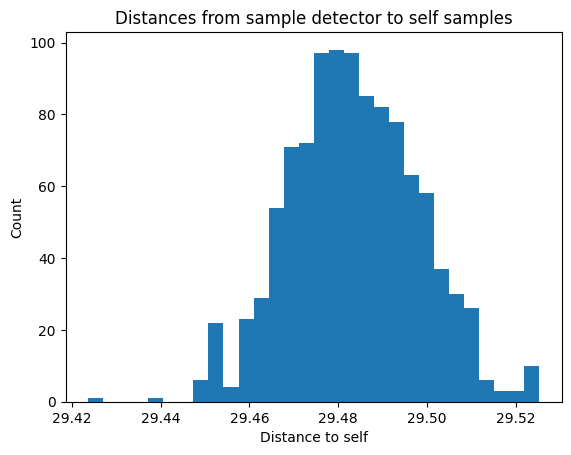

In [70]:
import matplotlib.pyplot as plt
import numpy as np

sample_detector = detectors[0]
distances = np.linalg.norm(self_matrix.toarray() - sample_detector, axis=1)

plt.hist(distances, bins=30)
plt.xlabel('Distance to self')
plt.ylabel('Count')
plt.title('Distances from sample detector to self samples')
plt.show()


In [71]:
import sys
sys.path.append('../') 

import src.negative_selection
import importlib
importlib.reload(src.negative_selection)

from src.negative_selection import detect_anomaly

# # Pick sample article (convert sparse to dense row)
# sample_article_vector = tfidf_matrix[0].toarray()[0]

# result = detect_anomaly(sample_article_vector, detectors, threshold)

# print("Article detected as FAKE" if result else "Article detected as REAL")

predictions = []

for i in range(tfidf_matrix.shape[0]):
    # Get article vector → convert sparse row to dense array
    article_vector = tfidf_matrix[i].toarray()[0]
    
    # Run detection
    detected = detect_anomaly(article_vector, detectors, threshold)
    
    # Map True/False → FAKE/REAL
    predictions.append('FAKE' if detected else 'REAL')

# Assign predictions to dataframe
df['predicted_label'] = predictions


In [72]:
accuracy = (df['label'] == df['predicted_label']).mean()
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 59.09%


In [73]:
df.groupby('label').count()

,id,news_url,title,tweet_ids,clean_text,predicted_label
label,,,,,,
FAKE,432,428,432,392,432,432
REAL,624,567,624,409,624,624


In [74]:
for t in [0.8, 0.7, 0.6, 0.5]:
    preds = []
    for i in range(tfidf_matrix.shape[0]):
        article_vector = tfidf_matrix[i].toarray()[0]
        detected = detect_anomaly(article_vector, detectors, t)
        preds.append('FAKE' if detected else 'REAL')
    acc = (df['label'] == preds).mean()
    print(f"Threshold {t}: Accuracy {acc:.2%}")


Threshold 0.8: Accuracy 59.09%
Threshold 0.7: Accuracy 59.09%
Threshold 0.6: Accuracy 59.09%
Threshold 0.5: Accuracy 59.09%
